In [1]:
import os, yaml, sys
import numpy as np
import matplotlib.pyplot as plt
import h5py
from IPython.display import clear_output
import random
ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from general_utils.utils import TimeSeries, dRSA, print_wise, get_lagplot
from general_utils.II import dynInformationImbalance
from project_specific_utils.dataloader import load_meg_data


In [183]:
from dataclasses import dataclass, field

@dataclass
class Cfg:
    sub_num = 3
    run = 3
    neu_fs = 100
    mod_fs = 23.976
    model_name = "pixelwise_lum";
    sq_side = 250
    downsampled_sq_size = 50
    sensors_group = 'par'
    model_name = "pixelwise_luminance"
    time_points = 200
    pseudotrials_n = 100
cfg = Cfg()

In [184]:
neu_rep1, labels = load_meg_data(paths, cfg.sub_num, cfg.run, cfg.sensors_group, cfg.neu_fs)
neu_rep2, labels = load_meg_data(paths, cfg.sub_num, cfg.run+3, cfg.sensors_group, cfg.neu_fs)

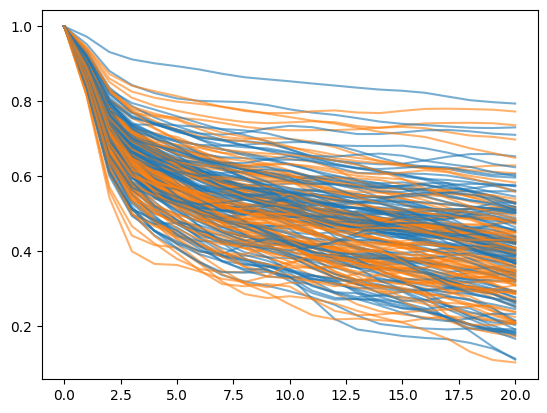

In [185]:
iteration_n = 300
cfg.time_points = 300
tot_rsa = np.zeros((cfg.time_points, cfg.time_points))
pseudotrials_idx = random.sample(range(len(neu_rep1)- cfg.time_points), cfg.pseudotrials_n)
for i_pst in pseudotrials_idx:
    subsamp_neu_rep1 = TimeSeries(neu_rep1[i_pst:i_pst+cfg.time_points], cfg.neu_fs)
    subsamp_neu_rep2 = TimeSeries(neu_rep2[i_pst:i_pst+cfg.time_points], cfg.neu_fs)
    _, autocorr_line1 = subsamp_neu_rep1.autocorr()
    _, autocorr_line2 = subsamp_neu_rep2.autocorr()
    plt.plot(autocorr_line1, color="tab:blue", alpha=.6)
    plt.plot(autocorr_line2, color="tab:orange", alpha=.6)


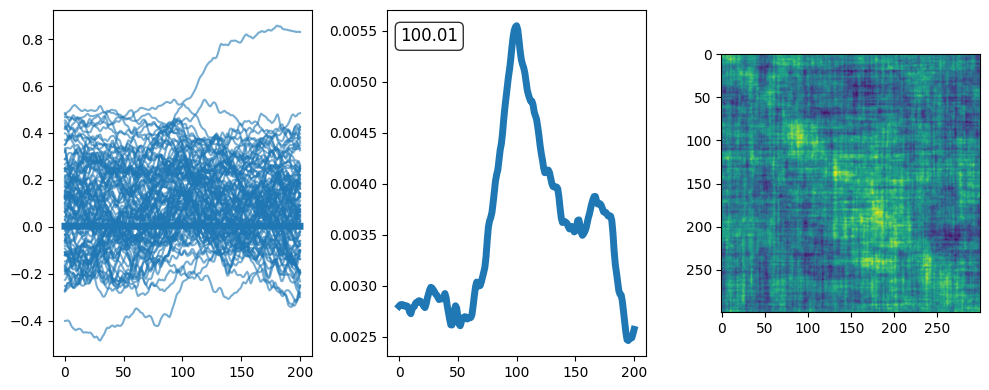

In [225]:
def softmax(x):
    x = np.asarray(x)
    e = np.exp(x - np.max(x))  # numerical stability
    return e / e.sum()

iteration_n = 3000
cfg.time_points = 300
tot_rsa = np.zeros((cfg.time_points, cfg.time_points))
pseudotrials_idx = random.sample(range(len(neu_rep1)- cfg.time_points), cfg.pseudotrials_n)
crosscorr_tot = np.zeros((cfg.time_points, cfg.time_points))
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
for i_pst in pseudotrials_idx:
    subsamp_neu_rep1 = TimeSeries(neu_rep1[i_pst:i_pst+cfg.time_points], cfg.neu_fs)
    subsamp_neu_rep2 = TimeSeries(neu_rep2[i_pst:i_pst+cfg.time_points], cfg.neu_fs)
    crosscorr = subsamp_neu_rep1.lagged_corr(subsamp_neu_rep2, metric="correlation")
    crosscorr_tot+=crosscorr    
    lp = get_lagplot(crosscorr,  max_lag=100)
    ax[0].plot(lp, color="tab:blue", alpha=.6)
avg_mat = crosscorr_tot/iteration_n
avg_lp = get_lagplot(avg_mat, max_lag=100)
ax[0].plot(avg_lp, linewidth=5)
ax[1].plot(avg_lp, linewidth=5)
peak = np.arange(len(avg_lp))@softmax(avg_lp)
ax[1].text(
    0.05, 0.95,                     # position (axes coords)
    round(peak,2),
    transform=ax[1].transAxes,     # ← important
    fontsize=12,
    verticalalignment='top',
    bbox=dict(
        boxstyle="round",
        facecolor="white",
        alpha=0.8,
        edgecolor="black"
    )
)
ax[2].imshow(avg_mat)
fig.tight_layout()

    # plt.plot(autocorr_line2, color="tab:orange", alpha=.6)
